# Imports

- https://github.com/camlab-ethz/ConvolutionalNeuralOperator/tree/main/CNO2d_vanilla_torch_version

In [1]:
from __future__ import annotations

import torch
from neuralop.models import FNO

from operator_aliasing.models.cno2d import CNO2d
from operator_aliasing.models.cno1d import CNO1d
from operator_aliasing.models.FNOModules import FNO2d
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Crop

In [2]:
# https://github.com/wenhangao21/ICLR25-CROP/blob/main/original_code_and_trained_models/Sec5_1_NS_with_low_Reynolds/CROP/CROP.py

import torch.nn.functional as F
import torch.nn as nn
#from utilities3 import *
from timeit import default_timer
import math
import argparse
import os

################################################################
# fourier layer
################################################################


class Spectral_weights(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        dtype = torch.cfloat
        self.kernel_size_Y = 2*modes1 - 1
        self.kernel_size_X = modes2
        self.W = nn.ParameterDict({
            'y0_modes': torch.nn.Parameter(torch.empty(in_channels, out_channels, modes1 - 1, 1, dtype=dtype)),
            'yposx_modes': torch.nn.Parameter(torch.empty(in_channels, out_channels, self.kernel_size_Y, self.kernel_size_X - 1, dtype=dtype)),
            '00_modes': torch.nn.Parameter(torch.empty(in_channels, out_channels, 1, 1, dtype=torch.float))
        })
        self.eval_build = True
        self.reset_parameters()
        self.get_weight()

    def reset_parameters(self):
        for v in self.W.values():
            nn.init.kaiming_uniform_(v, a=math.sqrt(5))
            
    def get_weight(self):
        if self.training:
            self.eval_build = True
        elif self.eval_build:
            self.eval_build = False
        else:
            return

        self.weights = torch.cat([self.W["y0_modes"], self.W["00_modes"].cfloat(), self.W["y0_modes"].flip(dims=(-2, )).conj()], dim=-2)
        self.weights = torch.cat([self.weights, self.W["yposx_modes"]], dim=-1)
        self.weights = self.weights.view(self.in_channels, self.out_channels,
                                         self.kernel_size_Y, self.kernel_size_X)
        

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.spectral_weight = Spectral_weights(in_channels=in_channels, out_channels=out_channels, modes1=modes1, modes2=modes2)
        self.get_weight()

    def get_weight(self):
        self.spectral_weight.get_weight()
        self.weights = self.spectral_weight.weights
        
    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]

        # get the index of the zero frequency and construct weight
        freq0_y = (torch.fft.fftshift(torch.fft.fftfreq(x.shape[-2])) == 0).nonzero().item()
        self.get_weight()
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.fftshift(torch.fft.rfft2(x), dim=-2)
        x_ft = x_ft[..., (freq0_y - self.modes1 + 1):(freq0_y + self.modes1), :self.modes2]
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1) // 2 + 1, dtype=torch.cfloat,
                             device=x.device)              
        out_ft[..., (freq0_y - self.modes1 + 1):(freq0_y + self.modes1), :self.modes2] = \
            self.compl_mul2d(x_ft, self.weights)


        # Return to physical space
        x = torch.fft.irfft2(torch.fft.ifftshift(out_ft, dim=-2), s=(x.size(-2), x.size(-1)))
        return x


class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv2d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv2d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x
        
class Crop_to_latent_size(nn.Module):
    def __init__(self, in_size, out_size):
        super(Crop_to_latent_size, self).__init__()
        self.in_size = in_size
        self.out_size = out_size
        self.temp_size = min(in_size, out_size)
    def forward(self, u1):
        B, C, _, _ = u1.shape
        fu1 = torch.fft.rfft2(u1, norm="ortho")
        fu1_recover = torch.zeros((B, C, self.out_size, self.out_size // 2 + 1), dtype=torch.complex64, device=u1.device)
        fu1_recover[:, :, :self.temp_size // 2, :self.temp_size // 2 + 1] = fu1[:, :, :self.temp_size // 2, :self.temp_size // 2 + 1]
        fu1_recover[:, :, -self.temp_size // 2:, :self.temp_size // 2 + 1] = fu1[:, :, -self.temp_size // 2:, :self.temp_size // 2 + 1]
        # Inverse FFT and scaling
        u1_recover = torch.fft.irfft2(fu1_recover, norm="ortho") * (self.out_size / self.in_size)
        return u1_recover

class CROP_FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width, in_size, latent_size, time_steps):
        super(CROP_FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x=64, y=64, c=12)
        output: the solution of the next timestep
        output shape: (batchsize, x=64, y=64, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.in_size = in_size
        self.latent_size = latent_size
        self.padding = 8 # pad the domain if input is non-periodic
        self.time_steps = time_steps
        
        self.CROP_to_latent = Crop_to_latent_size(self.in_size, self.latent_size)
        self.CROP_back = Crop_to_latent_size(self.latent_size, self.in_size)
        self.p = nn.Conv2d(self.time_steps, self.width, 1) # input channel is 12: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.norm = nn.InstanceNorm2d(self.width)
        self.q = MLP(self.width, 1, self.width * 4) # output channel is 1: u(x, y)

    def forward(self, x):
        #x = x.permute(0, 3, 1, 2)
        print("Pre projection: ", x.shape)
        x = self.CROP_to_latent(x)
        print("Post projection: ", x.shape)
        x = self.p(x)
        # x = F.pad(x, [0,self.padding, 0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.norm(self.conv0(self.norm(x)))
        x1 = self.mlp0(x1)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.norm(self.conv1(self.norm(x)))
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.norm(self.conv2(self.norm(x)))
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.norm(self.conv3(self.norm(x)))
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
        x = x1 + x2
        print("Pre crop back: ", x.shape)
        x = self.CROP_back(x)
        print("Post crop back: ", x.shape)

        # x = x[..., :-self.padding, :-self.padding] # pad the domain if input is non-periodic
        x = self.q(x)
        #x = x.permute(0, 2, 3, 1)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float, device=device)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float, device=device)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1)

In [15]:
modes1 = 32 # modes have to be less than half the latent size
modes2 = 16
width = 64
latent_size = 64 # Latent size has to be smaller or equal to smallest input dimension
in_size = 128 # The in_size is dynamically changed for different input!
batch_size = 2
time_steps = 1

crop_model = CROP_FNO2d(modes1, modes2, width, in_size, latent_size, time_steps).to(device)

x_data = torch.rand((batch_size, time_steps, in_size, in_size, )).type(torch.float32).to(device)

#x_data_transformed = torch.rand((32, 64, 64, 1)).type(torch.float32).to(device)

crop_model(x_data).shape

Pre projection:  torch.Size([2, 1, 128, 128])
Post projection:  torch.Size([2, 1, 64, 64])
Pre crop back:  torch.Size([2, 64, 64, 64])
Post crop back:  torch.Size([2, 64, 128, 128])


torch.Size([2, 1, 128, 128])

In [7]:
x_data.shape

torch.Size([2, 1, 64, 64])

# FNO Implementation

In [8]:
"""
Adopted From:
@author: Zongyi Li
This file is the Fourier Neural Operator for 2D problem such as the Navier-Stokes equation discussed in Section 5.3 in the [paper](https://arxiv.org/pdf/2010.08895.pdf),
which uses a recurrent structure to propagates in time.
"""
# https://github.com/wenhangao21/ICLR25-CROP/blob/main/original_code_and_trained_models/Sec5_1_NS_with_low_Reynolds/FNO/fno.py 

import torch.nn.functional as F
from timeit import default_timer
import math
import argparse
import os

################################################################
# fourier layer
################################################################


class Spectral_weights(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        dtype = torch.cfloat
        self.kernel_size_Y = 2*modes1 - 1
        self.kernel_size_X = modes2
        self.W = nn.ParameterDict({
            'y0_modes': torch.nn.Parameter(torch.empty(in_channels, out_channels, modes1 - 1, 1, dtype=dtype)),
            'yposx_modes': torch.nn.Parameter(torch.empty(in_channels, out_channels, self.kernel_size_Y, self.kernel_size_X - 1, dtype=dtype)),
            '00_modes': torch.nn.Parameter(torch.empty(in_channels, out_channels, 1, 1, dtype=torch.float))
        })
        self.eval_build = True
        self.reset_parameters()
        self.get_weight()

    def reset_parameters(self):
        for v in self.W.values():
            nn.init.kaiming_uniform_(v, a=math.sqrt(5))
            
    def get_weight(self):
        if self.training:
            self.eval_build = True
        elif self.eval_build:
            self.eval_build = False
        else:
            return

        self.weights = torch.cat([self.W["y0_modes"], self.W["00_modes"].cfloat(), self.W["y0_modes"].flip(dims=(-2, )).conj()], dim=-2)
        self.weights = torch.cat([self.weights, self.W["yposx_modes"]], dim=-1)
        self.weights = self.weights.view(self.in_channels, self.out_channels,
                                         self.kernel_size_Y, self.kernel_size_X)
        

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.spectral_weight = Spectral_weights(in_channels=in_channels, out_channels=out_channels, modes1=modes1, modes2=modes2)
        self.get_weight()

    def get_weight(self):
        self.spectral_weight.get_weight()
        self.weights = self.spectral_weight.weights
        
    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]

        # get the index of the zero frequency and construct weight
        freq0_y = (torch.fft.fftshift(torch.fft.fftfreq(x.shape[-2])) == 0).nonzero().item()
        self.get_weight()
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.fftshift(torch.fft.rfft2(x), dim=-2)
        x_ft = x_ft[..., (freq0_y - self.modes1 + 1):(freq0_y + self.modes1), :self.modes2]
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1) // 2 + 1, dtype=torch.cfloat,
                             device=x.device)              
        out_ft[..., (freq0_y - self.modes1 + 1):(freq0_y + self.modes1), :self.modes2] = \
            self.compl_mul2d(x_ft, self.weights)


        # Return to physical space
        x = torch.fft.irfft2(torch.fft.ifftshift(out_ft, dim=-2), s=(x.size(-2), x.size(-1)))
        return x


class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv2d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv2d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x

class FNO2d_custom(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d_custom, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x=64, y=64, c=12)
        output: the solution of the next timestep
        output shape: (batchsize, x=64, y=64, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 8 # pad the domain if input is non-periodic

        self.p = nn.Linear(12, self.width) # input channel is 12: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.norm = nn.InstanceNorm2d(self.width)
        self.q = MLP(self.width, 1, self.width * 4) # output channel is 1: u(x, y)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.p(x)
        x = x.permute(0, 3, 1, 2)
        # x = F.pad(x, [0,self.padding, 0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.norm(self.conv0(self.norm(x)))
        x1 = self.mlp0(x1)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.norm(self.conv1(self.norm(x)))
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.norm(self.conv2(self.norm(x)))
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.norm(self.conv3(self.norm(x)))
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
        x = x1 + x2

        # x = x[..., :-self.padding, :-self.padding] # pad the domain if input is non-periodic
        x = self.q(x)
        x = x.permute(0, 2, 3, 1)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float, device=device)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float, device=device)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1)



In [9]:
modes1 = 12
modes2 = 12
width = 20
in_size = 32

fno_model = FNO2d_custom(modes1, modes2, width).to(device)

x_data = torch.rand((batch_size, 2*in_size, 2*in_size, 10)).type(torch.float32).to(device)

#x_data_transformed = torch.rand((32, 64, 64, 1)).type(torch.float32).to(device)

fno_model(x_data).shape

torch.Size([2, 64, 64, 1])

# Original CNO

In [2]:
from operator_aliasing.models.CNO2d_original_version.CNOModule import CNO
from operator_aliasing.models.CNO2d_original_version.training.filtered_networks import LReLu, LReLu_regular, LReLu_torch

In [11]:
activation = LReLu_torch(in_channels =1, #In _channels is not used in these settings
                                            out_channels         = 1,                   
                                            in_size               = 32,                       
                                            out_size              = 32,                       
                                            in_sampling_rate      = 32,               
                                            out_sampling_rate     = 32)

In [12]:

x_data = torch.rand((batch_size, time_steps, 2*in_size, 2*in_size, )).type(torch.float32).to(device)
cno.lift.inter_CNOBlock.activation.activation(x_data).shape

torch.Size([2, 1, 64, 64])

In [3]:
modes1 = 16
modes2 = 16
width = 64
latent_size = 256
in_size = 37
batch_size = 2
time_steps = 1

x_data = torch.rand((batch_size, time_steps, 2*in_size, 2*in_size, )).type(torch.float32).to(device)

cno = CNO(
                 in_dim = time_steps,                    # Number of input channels.
                 in_size=in_size,                   # Input spatial size
                 N_layers=1,                  # Number of (D) or (U) blocks in the network
                 N_res = 1,                 # Number of (R) blocks per level (except the neck)
                 N_res_neck = 6,            # Number of (R) blocks in the neck
                 channel_multiplier = 32,   # How the number of channels evolve?
                 conv_kernel=3,             # Size of all the kernels
                 cutoff_den = 2.0001,       # Filter property 1.
                 filter_size=6,             # Filter property 2.
                 lrelu_upsampling = 2,      # Filter property 3.
                 half_width_mult  = 0.8,    # Filter property 4.
                 radial = False,            # Filter property 5. Is filter radial?
                 batch_norm = True,         # Add BN? We do not add BN in lifting/projection layer
                 out_dim = 1,               # Target dimension
                 out_size = 1,              # If out_size is 1, Then out_size = in_size. Else must be int
                 expand_input = False,      # Start with original in_size, or expand it (pad zeros in the spectrum)
                 latent_lift_proj_dim = 64, # Intermediate latent dimension in the lifting/projection layer
                 add_inv = True,            # Add invariant block (I) after the intermediate connections?
                 activation = 'cno_lrelu_torch'   # Activation function can be 'cno_lrelu' or 'lrelu'
                #activation='lrelu'                
).to(device)

cno(x_data).shape

torch.Size([2, 1, 74, 74])

In [37]:
x_data = torch.rand((batch_size, time_steps, in_size*4, in_size*4, )).type(torch.float32).to(device)
cno(x_data).shape

pre-lift torch.Size([2, 1, 320, 320])
pre upsample: torch.Size([2, 64, 320, 320])
post upsample: torch.Size([2, 64, 160, 160])
post downsample: torch.Size([2, 64, 80, 80])
post downsample 2.0: torch.Size([2, 64, 80, 80])
post-lift torch.Size([2, 16, 80, 80])
pre-activation: torch.Size([2, 16, 80, 80])
pre upsample: torch.Size([2, 16, 80, 80])
post upsample: torch.Size([2, 16, 160, 160])
post downsample: torch.Size([2, 16, 80, 80])
post downsample 2.0: torch.Size([2, 16, 80, 80])
post-activation: torch.Size([2, 16, 80, 80])
pre upsample: torch.Size([2, 32, 80, 80])
post upsample: torch.Size([2, 32, 160, 160])
post downsample: torch.Size([2, 32, 80, 80])
post downsample 2.0: torch.Size([2, 32, 40, 40])
pre-activation: torch.Size([2, 32, 40, 40])
pre upsample: torch.Size([2, 32, 40, 40])
post upsample: torch.Size([2, 32, 80, 80])
post downsample: torch.Size([2, 32, 40, 40])
post downsample 2.0: torch.Size([2, 32, 40, 40])
post-activation: torch.Size([2, 32, 40, 40])
pre-activation: torch.

torch.Size([2, 1, 80, 80])

In [5]:
# The CNO1d code has been modified from a tutorial featured in the 
# ETH Zurich course "AI in the Sciences and Engineering."
# Git page for this course: https://github.com/bogdanraonic3/AI_Science_Engineering 

# For up/downsampling, the antialias interpolation functions from the 
# torch library are utilized, limiting the ability to design
# your own low-pass filters at present.

# While acknowledging this suboptimal setup, the performance of CNO1d remains commendable. 
# Additionally, a training script is available, offering a solid foundation for personal projects.


import torch
import torch.nn as nn
import os
import numpy as np
import torch.nn.functional as F


# CNO LReLu activation fucntion
# CNO building block (CNOBlock) → Conv1d - BatchNorm - Activation
# Lift/Project Block (Important for embeddings)
# Residual Block → Conv1d - BatchNorm - Activation - Conv1d - BatchNorm - Skip Connection
# ResNet → Stacked ResidualBlocks (several blocks applied iteratively)


#---------------------
# Activation Function:
#---------------------

class CNO_LReLu(nn.Module):
    def __init__(self,
                in_size,
                out_size
                ):
        super(CNO_LReLu, self).__init__()

        self.in_size = in_size
        self.out_size = out_size
        self.act = nn.LeakyReLU()

    def forward(self, x):
        x = F.interpolate(x.unsqueeze(2), size = (1,2 * self.in_size), mode = "bicubic", antialias = True)
        x = self.act(x)
        x = F.interpolate(x, size = (1,self.out_size), mode = "bicubic", antialias = True)
        return x[:,:,0]

#--------------------
# CNO Block:
#--------------------

class CNOBlock(nn.Module):
    def __init__(self,
                in_channels,
                out_channels,
                in_size,
                out_size,
                use_bn = True
                ):
        super(CNOBlock, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.in_size  = in_size
        self.out_size = out_size

        #-----------------------------------------

        # We apply Conv -> BN (optional) -> Activation
        # Up/Downsampling happens inside Activation

        self.convolution = torch.nn.Conv1d(in_channels = self.in_channels,
                                            out_channels= self.out_channels,
                                            kernel_size = 3,
                                            padding     = 1)

        if use_bn:
            self.batch_norm  = nn.BatchNorm1d(self.out_channels)
        else:
            self.batch_norm  = nn.Identity()
        self.act           = CNO_LReLu(in_size  = self.in_size,
                                        out_size = self.out_size)
    def forward(self, x):
        x = self.convolution(x)
        x = self.batch_norm(x)
        return self.act(x)
    
#--------------------
# Lift/Project Block:
#--------------------

class LiftProjectBlock(nn.Module):
    def __init__(self,
                in_channels,
                out_channels,
                size,
                latent_dim = 64
                ):
        super(LiftProjectBlock, self).__init__()

        self.inter_CNOBlock = CNOBlock(in_channels       = in_channels,
                                        out_channels     = latent_dim,
                                        in_size          = size,
                                        out_size         = size,
                                        use_bn           = False)

        self.convolution = torch.nn.Conv1d(in_channels  = latent_dim,
                                            out_channels = out_channels,
                                            kernel_size  = 3,
                                            padding      = 1)


    def forward(self, x):
        x = self.inter_CNOBlock(x)
        x = self.convolution(x)
        return x

#--------------------
# Residual Block:
#--------------------

class ResidualBlock(nn.Module):
    def __init__(self,
                channels,
                size,
                use_bn = True
                ):
        super(ResidualBlock, self).__init__()

        self.channels = channels
        self.size     = size

        #-----------------------------------------

        # We apply Conv -> BN (optional) -> Activation -> Conv -> BN (optional) -> Skip Connection
        # Up/Downsampling happens inside Activation

        self.convolution1 = torch.nn.Conv1d(in_channels = self.channels,
                                            out_channels= self.channels,
                                            kernel_size = 3,
                                            padding     = 1)
        self.convolution2 = torch.nn.Conv1d(in_channels = self.channels,
                                            out_channels= self.channels,
                                            kernel_size = 3,
                                            padding     = 1)

        if use_bn:
            self.batch_norm1  = nn.BatchNorm1d(self.channels)
            self.batch_norm2  = nn.BatchNorm1d(self.channels)

        else:
            self.batch_norm1  = nn.Identity()
            self.batch_norm2  = nn.Identity()

        self.act           = CNO_LReLu(in_size  = self.size,
                                        out_size = self.size)


    def forward(self, x):
        out = self.convolution1(x)
        out = self.batch_norm1(out)
        out = self.act(out)
        out = self.convolution2(out)
        out = self.batch_norm2(out)
        return x + out

#--------------------
# ResNet:
#--------------------

class ResNet(nn.Module):
    def __init__(self,
                channels,
                size,
                num_blocks,
                use_bn = True
                ):
        super(ResNet, self).__init__()

        self.channels = channels
        self.size = size
        self.num_blocks = num_blocks

        self.res_nets = []
        for _ in range(self.num_blocks):
            self.res_nets.append(ResidualBlock(channels = channels,
                                                size = size,
                                                use_bn = use_bn))

        self.res_nets = torch.nn.Sequential(*self.res_nets)

    def forward(self, x):
        for i in range(self.num_blocks):
            x = self.res_nets[i](x)
        return x
    
    
#--------------------
# CNO:
#--------------------

class CNO1d(nn.Module):
    def __init__(self,
                in_dim,                    # Number of input channels.
                out_dim,                   # Number of input channels.
                size,                      # Input and Output spatial size (required )
                N_layers,                  # Number of (D) or (U) blocks in the network
                N_res = 4,                 # Number of (R) blocks per level (except the neck)
                N_res_neck = 4,            # Number of (R) blocks in the neck
                channel_multiplier = 16,   # How the number of channels evolve?
                use_bn = True,             # Add BN? We do not add BN in lifting/projection layer
                ):

        super(CNO1d, self).__init__()

        self.N_layers = int(N_layers)         # Number od (D) & (U) Blocks
        self.lift_dim = channel_multiplier//2 # Input is lifted to the half of channel_multiplier dimension
        self.in_dim   = in_dim
        self.out_dim  = out_dim
        self.channel_multiplier = channel_multiplier  # The growth of the channels

        ######## Num of channels/features - evolution ########

        self.encoder_features = [self.lift_dim] # How the features in Encoder evolve (number of features)
        for i in range(self.N_layers):
            self.encoder_features.append(2 ** i *   self.channel_multiplier)

        self.decoder_features_in = self.encoder_features[1:] # How the features in Decoder evolve (number of features)
        self.decoder_features_in.reverse()
        self.decoder_features_out = self.encoder_features[:-1]
        self.decoder_features_out.reverse()

        for i in range(1, self.N_layers):
            self.decoder_features_in[i] = 2*self.decoder_features_in[i] #Pad the outputs of the resnets (we must multiply by 2 then)

        ######## Spatial sizes of channels - evolution ########

        self.encoder_sizes = []
        self.decoder_sizes = []
        for i in range(self.N_layers + 1):
            self.encoder_sizes.append(size // 2 ** i)
            self.decoder_sizes.append(size // 2 ** (self.N_layers - i))


        ######## Define Lift and Project blocks ########

        self.lift   = LiftProjectBlock(in_channels = in_dim,
                                        out_channels = self.encoder_features[0],
                                        size = size)

        self.project   = LiftProjectBlock(in_channels = self.encoder_features[0] + self.decoder_features_out[-1],
                                            out_channels = out_dim,
                                            size = size)

        ######## Define Encoder, ED Linker and Decoder networks ########

        self.encoder         = nn.ModuleList([(CNOBlock(in_channels  = self.encoder_features[i],
                                                        out_channels = self.encoder_features[i+1],
                                                        in_size      = self.encoder_sizes[i],
                                                        out_size     = self.encoder_sizes[i+1],
                                                        use_bn       = use_bn))
                                                for i in range(self.N_layers)])

        # After the ResNets are executed, the sizes of encoder and decoder might not match (if out_size>1)
        # We must ensure that the sizes are the same, by aplying CNO Blocks
        self.ED_expansion     = nn.ModuleList([(CNOBlock(in_channels = self.encoder_features[i],
                                                        out_channels = self.encoder_features[i],
                                                        in_size      = self.encoder_sizes[i],
                                                        out_size     = self.decoder_sizes[self.N_layers - i],
                                                        use_bn       = use_bn))
                                                for i in range(self.N_layers + 1)])

        self.decoder         = nn.ModuleList([(CNOBlock(in_channels  = self.decoder_features_in[i],
                                                        out_channels = self.decoder_features_out[i],
                                                        in_size      = self.decoder_sizes[i],
                                                        out_size     = self.decoder_sizes[i+1],
                                                        use_bn       = use_bn))
                                                for i in range(self.N_layers)])

        ####################### Define ResNets Blocks ################################################################

        # Here, we define ResNet Blocks.

        # Operator UNet:
        # Outputs of the middle networks are patched (or padded) to corresponding sets of feature maps in the decoder

        self.res_nets = []
        self.N_res = int(N_res)
        self.N_res_neck = int(N_res_neck)

        # Define the ResNet networks (before the neck)
        for l in range(self.N_layers):
            self.res_nets.append(ResNet(channels = self.encoder_features[l],
                                        size = self.encoder_sizes[l],
                                        num_blocks = self.N_res,
                                        use_bn = use_bn))

        self.res_net_neck = ResNet(channels = self.encoder_features[self.N_layers],
                                    size = self.encoder_sizes[self.N_layers],
                                    num_blocks = self.N_res_neck,
                                    use_bn = use_bn)

        self.res_nets = torch.nn.Sequential(*self.res_nets)

    def forward(self, x):

        x = self.lift(x) #Execute Lift
        skip = []

        # Execute Encoder
        for i in range(self.N_layers):

            #Apply ResNet & save the result
            y = self.res_nets[i](x)
            skip.append(y)

            # Apply (D) block
            x = self.encoder[i](x)
            
        # Apply the deepest ResNet (bottle neck)
        x = self.res_net_neck(x)

        # Execute Decode
        for i in range(self.N_layers):

            # Apply (I) block (ED_expansion) & cat if needed
            if i == 0:
                x = self.ED_expansion[self.N_layers - i](x) #BottleNeck : no cat
            else:
                x = torch.cat((x, self.ED_expansion[self.N_layers - i](skip[-i])),1)

            # Apply (U) block
            x = self.decoder[i](x)

        # Cat & Execute Projetion
        x = torch.cat((x, self.ED_expansion[0](skip[0])),1)
        x = self.project(x)

        return x

In [10]:
width = 64
in_size = 27
batch_size = 2
time_steps = 1

x_data = torch.rand((batch_size, time_steps, 2*in_size*2, )).type(torch.float32).to(device)

model= CNO1d(
                time_steps,                    # Number of input channels.
                time_steps,                   # Number of input channels.
                in_size,                      # Input and Output spatial size (required )
                N_layers=4,                  # Number of (D) or (U) blocks in the network
                N_res = 4,                 # Number of (R) blocks per level (except the neck)
                N_res_neck = 4,            # Number of (R) blocks in the neck
                channel_multiplier = 16,   # How the number of channels evolve?
                use_bn = True,             # Add BN? We do not add BN in lifting/projection layer
                ).to(device)
model_output = model(x_data)
model_output.shape

torch.Size([2, 1, 27])

In [29]:
def resize(x, out_size, permute=False):
    if permute:
        x = x.permute(0, 3, 1, 2)
        
    f = torch.fft.rfft2(x, norm='backward')
    f_z = torch.zeros((*x.shape[:-2], out_size[0], out_size[1]//2 + 1), dtype=f.dtype, device=f.device)
    # 2k+1 -> (2k+1 + 1) // 2 = k+1 and (2k+1)//2 = k
    top_freqs1 = min((f.shape[-2] + 1) // 2, (out_size[0] + 1) // 2)
    top_freqs2 = min(f.shape[-1], out_size[1] // 2 + 1)
    # 2k -> (2k + 1) // 2 = k and (2k)//2 = k
    bot_freqs1 = min(f.shape[-2] // 2, out_size[0] // 2)
    bot_freqs2 = min(f.shape[-1], out_size[1] // 2 + 1)
    f_z[..., :top_freqs1, :top_freqs2] = f[..., :top_freqs1, :top_freqs2]
    f_z[..., -bot_freqs1:, :bot_freqs2] = f[..., -bot_freqs1:, :bot_freqs2]
    # x_z = torch.fft.ifft2(f_z, s=out_size).real
    x_z = torch.fft.irfft2(f_z, s=out_size).real
    print(f_z.shape, out_size)
    x_z = x_z * (out_size[0] / x.shape[-2]) * (out_size[1] / x.shape[-1])
 
    # f_z[..., -f.shape[-2]//2:, :f.shape[-1]] = f[..., :f.shape[-2]//2+1, :]
 
    if permute:
        x_z = x_z.permute(0, 2, 3, 1)
    return x_z
    
x_data = torch.rand((batch_size, time_steps, 2*in_size*2, 2*in_size*2))
resize(x_data, (375,375), permute=False).shape

torch.Size([2, 1, 375, 188]) (375, 375)


torch.Size([2, 1, 375, 375])

In [38]:
class Crop_to_latent_size(nn.Module):
    def __init__(self, in_size, out_size):
        super(Crop_to_latent_size, self).__init__()
        self.in_size = in_size
        self.out_size = out_size
        self.temp_size = min(in_size, out_size)
    def forward(self, u1):
        B, C, _, _ = u1.shape
        fu1 = torch.fft.rfft2(u1, norm="ortho")
        fu1_recover = torch.zeros((B, C, self.out_size, self.out_size // 2 + 1), dtype=torch.complex64, device=u1.device)
        fu1_recover[:, :, :self.temp_size // 2, :self.temp_size // 2 + 1] = fu1[:, :, :self.temp_size // 2, :self.temp_size // 2 + 1]
        fu1_recover[:, :, -self.temp_size // 2:, :self.temp_size // 2 + 1] = fu1[:, :, -self.temp_size // 2:, :self.temp_size // 2 + 1]
        # Inverse FFT and scaling
        print(fu1_recover.shape)
        u1_recover = torch.fft.irfft2(fu1_recover, norm="ortho", s=(self.out_size,self.out_size)) * (self.out_size / self.in_size)
        return u1_recover

in_size = 37
x_data = torch.rand((batch_size, time_steps, in_size, in_size))
proj = Crop_to_latent_size(in_size, 39)
proj(x_data).shape

torch.Size([2, 1, 39, 20])


torch.Size([2, 1, 39, 39])

In [ ]:
def resize(x, out_size, permute=False):
    if permute:
        x = x.permute(0, 3, 1, 2)
        
    f = torch.fft.rfft2(x, norm='backward')
    f_z = torch.zeros((*x.shape[:-2], out_size[0], out_size[1]//2 + 1), dtype=f.dtype, device=f.device)

    
    # 2k+1 -> (2k+1 + 1) // 2 = k+1 and (2k+1)//2 = k
    top_freqs1 = min((f.shape[-2] + 1) // 2, (out_size[0] + 1) // 2)
    top_freqs2 = min(f.shape[-1], out_size[1] // 2 + 1)
    # 2k -> (2k + 1) // 2 = k and (2k)//2 = k
    bot_freqs1 = min(f.shape[-2] // 2, out_size[0] // 2)
    bot_freqs2 = min(f.shape[-1], out_size[1] // 2 + 1)

    
    f_z[..., :top_freqs1, :top_freqs2] = f[..., :top_freqs1, :top_freqs2]
    f_z[..., -bot_freqs1:, :bot_freqs2] = f[..., -bot_freqs1:, :bot_freqs2]
    # x_z = torch.fft.ifft2(f_z, s=out_size).real
    x_z = torch.fft.irfft2(f_z, s=out_size).real
    x_z = x_z * (out_size[0] / x.shape[-2]) * (out_size[1] / x.shape[-1])
 
    # f_z[..., -f.shape[-2]//2:, :f.shape[-1]] = f[..., :f.shape[-2]//2+1, :]
 
    if permute:
        x_z = x_z.permute(0, 2, 3, 1)
    return x_z

In [13]:
def resize_1D(x, out_size, permute=False):
    # based on https://github.com/camlab-ethz/ConvolutionalNeuralOperator/blob/main/CNO2d_original_version/Error_Distribution_VaryingResolution.py#L119C1-L141C15
    if permute:
        x = x.permute(0, 3, 1, 2)

    f = torch.fft.rfftn(x, norm='backward', s = x.shape[-1])

    f_z = torch.zeros((*x.shape[:-1], out_size[0] // 2 + 1), dtype=f.dtype, device=f.device)
    # 2k+1 -> (2k+1 + 1) // 2 = k+1 and (2k+1)//2 = k
    top_freqs1 = min((f.shape[-1]), (out_size[0] // 2 + 1))
    f_z[..., :top_freqs1] = f[..., :top_freqs1]
    x_z = torch.fft.irfftn(f_z,s=out_size[0]).real
    x_z = x_z * (out_size[0] / x.shape[-2]) #* (out_size[1] / x.shape[-1])

    if permute:
        x_z = x_z.permute(0, 2, 3, 1)
    return x_z

time_steps = 1
in_size = 100
batch_size = 1
x_data = torch.rand((batch_size, time_steps, 1, in_size))
upsample = resize_1D(x_data, (320,), permute=False)

In [12]:
upsample.shape

torch.Size([1, 1, 320])

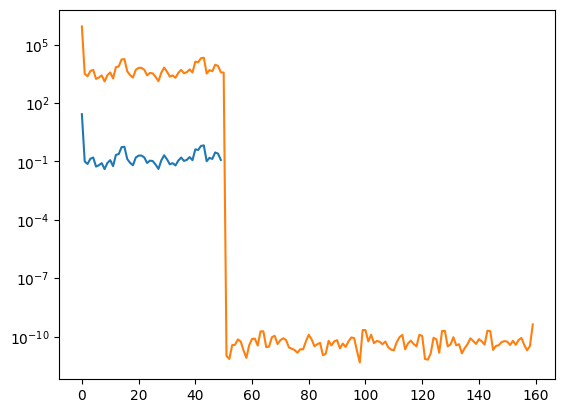

In [153]:
from operator_aliasing.utils import get_energy_curve_1d
import matplotlib.pyplot as plt

original_spectrum = get_energy_curve_1d(x_data)

upsample_spectrum = get_energy_curve_1d(upsample)


plt.plot(original_spectrum)
plt.plot(upsample_spectrum)
plt.yscale("log")

In [15]:
# Implementation of the filters is borrowed from paper "Alias-Free Generative Adversarial Networks (StyleGAN3)" https://nvlabs.github.io/stylegan3/
# Copyright (c) 2021, NVIDIA CORPORATION & AFFILIATES.  All rights reserved.
#
# NVIDIA CORPORATION and its licensors retain all intellectual property
# and proprietary rights in and to this software, related documentation
# and any modifications thereto.  Any use, reproduction, disclosure or
# distribution of this software and related documentation without an express
# license agreement from NVIDIA CORPORATION is strictly prohibited.

#-------------------------------------------------------------------------------

import torch.nn as nn

import torch
from torch.nn import LeakyReLU as LReLu
#------------------------------------------------------------------------------

#Depending on in_size, out_size, the CNOBlock can be:
#   -- (D) Block
#   -- (U) Block
#   -- (I) Block

class CNOBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 in_size,
                 out_size,
                 cutoff_den = 2.0001,
                 conv_kernel = 3,
                 filter_size = 6,
                 lrelu_upsampling = 2,
                 half_width_mult  = 0.8,
                 radial = False,
                 batch_norm = True,
                 activation = 'cno_lrelu'
                 ):
        super(CNOBlock, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.in_size  = in_size
        self.out_size = out_size
        self.conv_kernel = conv_kernel
        self.batch_norm = batch_norm
        
        #---------- Filter properties -----------
        self.citically_sampled = False #We use w_c = s/2.0001 --> NOT critically sampled

        if cutoff_den == 2.0:
            self.citically_sampled = True
        self.in_cutoff  = self.in_size / cutoff_den
        self.out_cutoff = self.out_size / cutoff_den
        
        self.in_halfwidth =  half_width_mult*self.in_size - self.in_size / cutoff_den
        self.out_halfwidth = half_width_mult*self.out_size - self.out_size / cutoff_den
        
        #-----------------------------------------

        # We apply Conv -> BN (optional) -> Activation
        # Up/Downsampling happens inside Activation
        
        pad = (self.conv_kernel-1)//2
        self.convolution = torch.nn.Conv2d(in_channels = self.in_channels, out_channels=self.out_channels, 
                                           kernel_size=self.conv_kernel, 
                                           padding = pad)
    
        if self.batch_norm:
            self.batch_norm  = nn.BatchNorm2d(self.out_channels)
        self.activation = LReLu() 
        if activation == "cno_lrelu_torch":
            self.activation = LReLu_torch(in_channels           = self.out_channels, #In _channels is not used in these settings
                                            out_channels          = self.out_channels,                   
                                            in_size               = self.in_size,                       
                                            out_size              = self.out_size,                       
                                            in_sampling_rate      = self.in_size,               
                                            out_sampling_rate     = self.out_size)
        
        
    def forward(self, x):
        x = self.convolution(x)
        if self.batch_norm:
            x = self.batch_norm(x)
        return self.activation(x)

#------------------------------------------------------------------------------

# Contains CNOBlock -> Convolution -> BN

class LiftProjectBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 in_size,
                 out_size,
                 latent_dim = 64,
                 cutoff_den = 2.0001,
                 conv_kernel = 3,
                 filter_size = 6,
                 lrelu_upsampling = 2,
                 half_width_mult  = 0.8,
                 radial = False,
                 batch_norm = True,
                 activation = 'cno_lrelu'
                 ):
        super(LiftProjectBlock, self).__init__()
    
        self.inter_CNOBlock = CNOBlock(in_channels = in_channels,
                                    out_channels = latent_dim,
                                    in_size = in_size,
                                    out_size = out_size,
                                    cutoff_den = cutoff_den,
                                    conv_kernel = conv_kernel,
                                    filter_size = filter_size,
                                    lrelu_upsampling = lrelu_upsampling,
                                    half_width_mult  = half_width_mult,
                                    radial = radial,
                                    batch_norm = batch_norm,
                                    activation = activation)
        
        pad = (conv_kernel-1)//2
        self.convolution = torch.nn.Conv2d(in_channels = latent_dim, out_channels=out_channels, 
                                           kernel_size=conv_kernel, stride = 1, 
                                           padding = pad)
        
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.batch_norm  = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = self.inter_CNOBlock(x)
        
        x = self.convolution(x)
        if self.batch_norm:
            x = self.batch_norm(x)
        return x
        
#------------------------------------------------------------------------------

# Residual Block containts:
    # Convolution -> BN -> Activation -> Convolution -> BN -> SKIP CONNECTION

class ResidualBlock(nn.Module):
    def __init__(self,
                 channels,
                 size,
                 cutoff_den = 2.0001,
                 conv_kernel = 3,
                 filter_size = 6,
                 lrelu_upsampling = 2,
                 half_width_mult  = 0.8,
                 radial = False,
                 batch_norm = True,
                 activation = 'cno_lrelu'
                 ):
        super(ResidualBlock, self).__init__()

        self.channels = channels
        self.size  = size
        self.conv_kernel = conv_kernel
        self.batch_norm = batch_norm

        #---------- Filter properties -----------
        self.citically_sampled = False #We use w_c = s/2.0001 --> NOT critically sampled

        if cutoff_den == 2.0:
            self.citically_sampled = True
        self.cutoff  = self.size / cutoff_den        
        self.halfwidth =  half_width_mult*self.size - self.size / cutoff_den
        
        #-----------------------------------------
        
        pad = (self.conv_kernel-1)//2
        self.convolution1 = torch.nn.Conv2d(in_channels = self.channels, out_channels=self.channels, 
                                           kernel_size=self.conv_kernel, stride = 1, 
                                           padding = pad)
        self.convolution2 = torch.nn.Conv2d(in_channels = self.channels, out_channels=self.channels, 
                                           kernel_size=self.conv_kernel, stride = 1, 
                                           padding = pad)
        
        if self.batch_norm:
            self.batch_norm1  = nn.BatchNorm2d(self.channels)
            self.batch_norm2  = nn.BatchNorm2d(self.channels)
        self.activation = LReLu() 
        if activation == "cno_lrelu_torch":
            print("custom activation")
            self.activation = LReLu_torch(in_channels           = self.channels, #In _channels is not used in these settings
                                            out_channels          = self.channels,                   
                                            in_size               = self.size,                       
                                            out_size              = self.size,                       
                                            in_sampling_rate      = self.size,               
                                            out_sampling_rate     = self.size)

    def forward(self, x):
        out = self.convolution1(x)
        if self.batch_norm:
            out = self.batch_norm1(out)
        print("pre-activation:",out.shape)
        out = self.activation(out)
        print("post-activation:",out.shape)
        out = self.convolution2(out)
        if self.batch_norm:
            out = self.batch_norm2(out)
        
        return x + out
#------------------------------------------------------------------------------

#CNO NETWORK:
class CNO(nn.Module):
    def __init__(self,  
                 in_dim,                    # Number of input channels.
                 in_size,                   # Input spatial size
                 N_layers,                  # Number of (D) or (U) blocks in the network
                 N_res = 1,                 # Number of (R) blocks per level (except the neck)
                 N_res_neck = 6,            # Number of (R) blocks in the neck
                 channel_multiplier = 32,   # How the number of channels evolve?
                 conv_kernel=3,             # Size of all the kernels
                 cutoff_den = 2.0001,       # Filter property 1.
                 filter_size=6,             # Filter property 2.
                 lrelu_upsampling = 2,      # Filter property 3.
                 half_width_mult  = 0.8,    # Filter property 4.
                 radial = False,            # Filter property 5. Is filter radial?
                 batch_norm = True,         # Add BN? We do not add BN in lifting/projection layer
                 out_dim = 1,               # Target dimension
                 out_size = 1,              # If out_size is 1, Then out_size = in_size. Else must be int
                 expand_input = False,      # Start with original in_size, or expand it (pad zeros in the spectrum)
                 latent_lift_proj_dim = 64, # Intermediate latent dimension in the lifting/projection layer
                 add_inv = True,            # Add invariant block (I) after the intermediate connections?
                 activation = 'cno_lrelu'   # Activation function can be 'cno_lrelu' or 'lrelu'
                ):
        
        super(CNO, self).__init__()

        ###################### Define the parameters & specifications #################################################

        
        # Number od (D) & (U) Blocks
        self.N_layers = int(N_layers)
        
        # Input is lifted to the half on channel_multiplier dimension
        self.lift_dim = channel_multiplier//2         
        self.out_dim  = out_dim
        
        #Should we add invariant layers in the decoder?
        self.add_inv = add_inv
        
        # The growth of the channels : d_e parametee
        self.channel_multiplier = channel_multiplier        
        
        # Is the filter radial? We always use NOT radial
        if radial ==0:
            self.radial = False
        else:
            self.radial = True
        
        ###################### Define evolution of the number features ################################################

        # How the features in Encoder evolve (number of features)
        self.encoder_features = [self.lift_dim]
        for i in range(self.N_layers):
            self.encoder_features.append(2 ** i *   self.channel_multiplier)
        
        # How the features in Decoder evolve (number of features)
        self.decoder_features_in = self.encoder_features[1:]
        self.decoder_features_in.reverse()
        self.decoder_features_out = self.encoder_features[:-1]
        self.decoder_features_out.reverse()

        for i in range(1, self.N_layers):
            self.decoder_features_in[i] = 2*self.decoder_features_in[i] #Pad the outputs of the resnets
        
        self.inv_features = self.decoder_features_in
        self.inv_features.append(self.encoder_features[0] + self.decoder_features_out[-1])
        
        ###################### Define evolution of sampling rates #####################################################
        
        if not expand_input:
            latent_size = in_size # No change in in_size
        else:
            down_exponent = 2 ** N_layers
            latent_size = in_size - (in_size % down_exponent) + down_exponent # Jump from 64 to 72, for example
        
        #Are inputs and outputs of the same size? If not, how should the size of the decoder evolve?
        if out_size == 1:
            latent_size_out = latent_size
        else:
            if not expand_input:
                latent_size_out = out_size # No change in in_size
            else:
                down_exponent = 2 ** N_layers
                latent_size_out = out_size - (out_size % down_exponent) + down_exponent # Jump from 64 to 72, for example
        
        self.encoder_sizes = []
        self.decoder_sizes = []
        for i in range(self.N_layers + 1):
            self.encoder_sizes.append(latent_size // 2 ** i)
            self.decoder_sizes.append(latent_size_out // 2 ** (self.N_layers - i))
        
        
        
        ###################### Define Projection & Lift ##############################################################
    
        self.lift = LiftProjectBlock(in_channels  = in_dim,
                                     out_channels = self.encoder_features[0],
                                     in_size      = in_size,
                                     out_size     = self.encoder_sizes[0],
                                     latent_dim   = latent_lift_proj_dim,
                                     cutoff_den   = cutoff_den,
                                     conv_kernel  = conv_kernel,
                                     filter_size  = filter_size,
                                     lrelu_upsampling  = lrelu_upsampling,
                                     half_width_mult   = half_width_mult,
                                     radial            = radial,
                                     batch_norm        = False,
                                     activation = activation)
        _out_size = out_size
        if out_size == 1:
            _out_size = in_size
            
        self.project = LiftProjectBlock(in_channels  = self.encoder_features[0] + self.decoder_features_out[-1],
                                        out_channels = out_dim,
                                        in_size      = self.decoder_sizes[-1],
                                        out_size     = _out_size,
                                        latent_dim   = latent_lift_proj_dim,
                                        cutoff_den   = cutoff_den,
                                        conv_kernel  = conv_kernel,
                                        filter_size  = filter_size,
                                        lrelu_upsampling  = lrelu_upsampling,
                                        half_width_mult   = half_width_mult,
                                        radial            = radial,
                                        batch_norm        = False,
                                        activation = activation) 

        ###################### Define U & D blocks ###################################################################

        self.encoder         = nn.ModuleList([(CNOBlock(in_channels  = self.encoder_features[i],
                                                        out_channels = self.encoder_features[i+1],
                                                        in_size      = self.encoder_sizes[i],
                                                        out_size     = self.encoder_sizes[i+1],
                                                        cutoff_den   = cutoff_den,
                                                        conv_kernel  = conv_kernel,
                                                        filter_size  = filter_size,
                                                        lrelu_upsampling = lrelu_upsampling,
                                                        half_width_mult  = half_width_mult,
                                                        radial = radial,
                                                        batch_norm = batch_norm,
                                                        activation = activation))                                  
                                               for i in range(self.N_layers)])
        
        # After the ResNets are executed, the sizes of encoder and decoder might not match (if out_size>1)
        # We must ensure that the sizes are the same, by aplying CNO Blocks
        self.ED_expansion     = nn.ModuleList([(CNOBlock(in_channels = self.encoder_features[i],
                                                        out_channels = self.encoder_features[i],
                                                        in_size      = self.encoder_sizes[i],
                                                        out_size     = self.decoder_sizes[self.N_layers - i],
                                                        cutoff_den   = cutoff_den,
                                                        conv_kernel  = conv_kernel,
                                                        filter_size  = filter_size,
                                                        lrelu_upsampling = lrelu_upsampling,
                                                        half_width_mult  = half_width_mult,
                                                        radial = radial,
                                                        batch_norm = batch_norm,
                                                        activation = activation))                                  
                                               for i in range(self.N_layers + 1)])
        
        self.decoder         = nn.ModuleList([(CNOBlock(in_channels  = self.decoder_features_in[i],
                                                        out_channels = self.decoder_features_out[i],
                                                        in_size      = self.decoder_sizes[i],
                                                        out_size     = self.decoder_sizes[i+1],
                                                        cutoff_den   = cutoff_den,
                                                        conv_kernel  = conv_kernel,
                                                        filter_size  = filter_size,
                                                        lrelu_upsampling = lrelu_upsampling,
                                                        half_width_mult  = half_width_mult,
                                                        radial = radial,
                                                        batch_norm = batch_norm,
                                                        activation = activation))                                  
                                               for i in range(self.N_layers)])
        
        
        self.decoder_inv    = nn.ModuleList([(CNOBlock(in_channels  =  self.inv_features[i],
                                                        out_channels = self.inv_features[i],
                                                        in_size      = self.decoder_sizes[i],
                                                        out_size     = self.decoder_sizes[i],
                                                        cutoff_den   = cutoff_den,
                                                        conv_kernel  = conv_kernel,
                                                        filter_size  = filter_size,
                                                        lrelu_upsampling = lrelu_upsampling,
                                                        half_width_mult  = half_width_mult,
                                                        radial = radial,
                                                        batch_norm = batch_norm,
                                                        activation = activation))                                  
                                               for i in range(self.N_layers + 1)])
        
        
        ####################### Define ResNets Blocks ################################################################

        # Here, we define ResNet Blocks. 
        # We also define the BatchNorm layers applied BEFORE the ResNet blocks 
        
        # Operator UNet:
        # Outputs of the middle networks are patched (or padded) to corresponding sets of feature maps in the decoder 

        self.res_nets = []
        self.N_res = int(N_res)
        self.N_res_neck = int(N_res_neck)

        # Define the ResNet blocks & BatchNorm
        for l in range(self.N_layers):
            for i in range(self.N_res):
                self.res_nets.append(ResidualBlock(channels = self.encoder_features[l],
                                                   size     = self.encoder_sizes[l],
                                                   cutoff_den = cutoff_den,
                                                   conv_kernel = conv_kernel,
                                                   filter_size = filter_size,
                                                   lrelu_upsampling = lrelu_upsampling,
                                                   half_width_mult  = half_width_mult,
                                                   radial = radial,
                                                   batch_norm = batch_norm,
                                                   activation = activation))
        for i in range(self.N_res_neck):
            self.res_nets.append(ResidualBlock(channels = self.encoder_features[self.N_layers],
                                               size     = self.encoder_sizes[self.N_layers],
                                               cutoff_den = cutoff_den,
                                               conv_kernel = conv_kernel,
                                               filter_size = filter_size,
                                               lrelu_upsampling = lrelu_upsampling,
                                               half_width_mult  = half_width_mult,
                                               radial = radial,
                                               batch_norm = batch_norm,
                                               activation = activation))
        
        self.res_nets = torch.nn.Sequential(*self.res_nets)    


    def forward(self, x):
                 
        #Execute Lift ---------------------------------------------------------
        print("pre-lift", x.shape)
        x = self.lift(x)
        print("post-lift", x.shape)
        skip = []
        
        # Execute Encoder -----------------------------------------------------
        for i in range(self.N_layers):
            
            #Apply ResNet & save the result
            y = x
            for j in range(self.N_res):
                y = self.res_nets[i*self.N_res + j](y)
            skip.append(y)
            
            # Apply (D) block
            x = self.encoder[i](x)   
        
        #----------------------------------------------------------------------
        
        # Apply the deepest ResNet (bottle neck)
        for j in range(self.N_res_neck):
            x = self.res_nets[-j-1](x)

        # Execute Decoder -----------------------------------------------------
        for i in range(self.N_layers):
            
            # Apply (I) block (ED_expansion) & cat if needed
            if i == 0:
                x = self.ED_expansion[self.N_layers - i](x) #BottleNeck : no cat
            else:
                x = torch.cat((x, self.ED_expansion[self.N_layers - i](skip[-i])),1)
            
            if self.add_inv:
                x = self.decoder_inv[i](x)
            # Apply (U) block
            x = self.decoder[i](x)
        # Cat & Execute Projetion ---------------------------------------------
        
        x = torch.cat((x, self.ED_expansion[0](skip[0])),1)
        print("pre-projection", x.shape)
        x = self.project(x)
        print("post-projection", x.shape)
        
        del skip
        del y
        
        return x


    def get_n_params(self):
        pp = 0
        
        for p in list(self.parameters()):
            nn = 1
            for s in list(p.size()):
                nn = nn * s
            pp += nn
        return pp

    def print_size(self):
        nparams = 0
        nbytes = 0

        for param in self.parameters():
            nparams += param.numel()
            nbytes += param.data.element_size() * param.numel()

        print(f'Total number of model parameters: {nparams}')

        return nparams

In [16]:
modes1 = 16
modes2 = 16
width = 64
in_size = 27
batch_size = 2
time_steps = 1

x_data = torch.rand((batch_size, time_steps, 2*in_size* 2, 2*in_size*2, )).type(torch.float32).to(device)

cno = CNO(
                 in_dim = time_steps,                    # Number of input channels.
                 in_size=in_size,                   # Input spatial size
                 N_layers=1,                  # Number of (D) or (U) blocks in the network
                 N_res = 1,                 # Number of (R) blocks per level (except the neck)
                 N_res_neck = 6,            # Number of (R) blocks in the neck
                 channel_multiplier = 32,   # How the number of channels evolve?
                 conv_kernel=3,             # Size of all the kernels
                 cutoff_den = 2.0001,       # Filter property 1.
                 filter_size=6,             # Filter property 2.
                 lrelu_upsampling = 2,      # Filter property 3.
                 half_width_mult  = 0.8,    # Filter property 4.
                 radial = False,            # Filter property 5. Is filter radial?
                 batch_norm = True,         # Add BN? We do not add BN in lifting/projection layer
                 out_dim = 1,               # Target dimension
                 out_size = 1,              # If out_size is 1, Then out_size = in_size. Else must be int
                 expand_input = False,      # Start with original in_size, or expand it (pad zeros in the spectrum)
                 latent_lift_proj_dim = 38, # Intermediate latent dimension in the lifting/projection layer (channels)
                 add_inv = True,            # Add invariant block (I) after the intermediate connections?
                 activation = 'cno_lrelu'   # Activation function can be 'cno_lrelu' or 'lrelu'
                ).to(device)

cno(x_data).shape

pre-lift torch.Size([2, 1, 108, 108])
post-lift torch.Size([2, 16, 108, 108])
pre-activation: torch.Size([2, 16, 108, 108])
post-activation: torch.Size([2, 16, 108, 108])
pre-activation: torch.Size([2, 32, 108, 108])
post-activation: torch.Size([2, 32, 108, 108])
pre-activation: torch.Size([2, 32, 108, 108])
post-activation: torch.Size([2, 32, 108, 108])
pre-activation: torch.Size([2, 32, 108, 108])
post-activation: torch.Size([2, 32, 108, 108])
pre-activation: torch.Size([2, 32, 108, 108])
post-activation: torch.Size([2, 32, 108, 108])
pre-activation: torch.Size([2, 32, 108, 108])
post-activation: torch.Size([2, 32, 108, 108])
pre-activation: torch.Size([2, 32, 108, 108])
post-activation: torch.Size([2, 32, 108, 108])
pre-projection torch.Size([2, 32, 108, 108])
post-projection torch.Size([2, 1, 108, 108])


torch.Size([2, 1, 108, 108])

In [17]:
x_data.shape

torch.Size([2, 1, 108, 108])

In [18]:
x_data = torch.rand((batch_size, time_steps, 128, 128, )).type(torch.float32).to(device)
cno.lift.inter_CNOBlock.activation(x_data).shape

torch.Size([2, 1, 128, 128])

# Multi-resolution inference

In [19]:
x_data = torch.rand((32, 1, 128, 128)).type(torch.float32).to(device)
y_data = torch.ones((32, 1, 128, 128)).type(torch.float32).to(device)

In [39]:
N_layers = 1
N_res = 4
N_res_neck = 4
channel_multiplier = 16

s = 128

model_args = {
    'in_dim': 1,  # Number of input channels.
    'out_dim': 1,  # Number of output channels.
    #'size': s,  # Input and Output spatial size (required )
    'n_layers': N_layers,  # Number of (D) or (U) blocks in the network
    'n_res': N_res,  # Number of (R) blocks per level (except the neck)
    'n_res_neck': N_res_neck,  # Number of (R) blocks in the neck
    'channel_multiplier': channel_multiplier,  # How num channels evolve?
    'use_bn': False,
}
cno = CNO2d(**model_args)
cno = cno.to(device)

In [10]:
N_layers = 1
N_res = 4
N_res_neck = 4
channel_multiplier = 16

s = 128

model_args = {
    'in_dim': 10,  # Number of input channels.
    'out_dim': 1,  # Number of output channels.
    'size': s,  # Input and Output spatial size (required )
    'N_layers': N_layers,  # Number of (D) or (U) blocks in the network
    'N_res': N_res,  # Number of (R) blocks per level (except the neck)
    'N_res_neck': N_res_neck,  # Number of (R) blocks in the neck
    'channel_multiplier': channel_multiplier,  # How num channels evolve?
    'use_bn': False,
}
cno = CNO1d(**model_args)
cno = cno.to(device)

x_data_transformed = torch.rand((32, 10,1 16)).type(torch.float32).to(device)
cno(x_data_transformed).shape

RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [32, 10, 1, 128]

In [21]:
max_modes = 16
starting_modes = (max_modes, max_modes)
model = FNO(
    max_n_modes=(max_modes, max_modes),
    n_modes=starting_modes,
    hidden_channels=32,
    in_channels=1,
    out_channels=1,
).to(device)

In [22]:
fno_architecture = {
    'width': 64,
    'modes': 16,
    'FourierF': 0,  # Num Fourier Features in the input channels. Default is 0.
    'n_layers': 4,  # Number of Fourier layers
    'padding': 0,
    'include_grid': 0,
    'retrain': 4,  # Random seed
}

fno = FNO2d(fno_architecture, device=device).to(device)

x_data_transformed = torch.rand((32, 64, 64, 1)).type(torch.float32).to(device)

fno(x_data_transformed).shape

torch.Size([32, 64, 64, 1])

In [23]:
model(x_data).shape

torch.Size([32, 1, 128, 128])

In [24]:
4096 / 32

128.0

In [25]:
cno(x_data).shape

torch.Size([32, 1, 128, 128])

In [26]:
x_data_small = torch.rand((32, 1, 64, 64)).type(torch.float32).to(device)
y_data_small = torch.ones((32, 1, 64, 64)).type(torch.float32).to(device)
cno(x_data_small).shape

# model(x_data_small).shape

torch.Size([32, 1, 64, 64])

In [27]:
x_data_large = torch.rand((1, 1, 256, 256)).type(torch.float32).to(device)
y_data_large = torch.ones((1, 1, 256, 256)).type(torch.float32).to(device)
cno(x_data_large).shape

torch.Size([1, 1, 256, 256])

In [28]:
import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

# --------------------------------------
# REPLACE THIS PART BY YOUR DATALOADER
# --------------------------------------

n_train = 100  # number of training samples

x_data = (
    torch.rand((256, 1, 128, 128))
    .type(torch.float32)
    .reshape(256, 128, 128, 1)
)
y_data = (
    torch.ones((256, 1, 128, 128))
    .type(torch.float32)
    .reshape(256, 128, 128, 1)
)

input_function_train = x_data[:n_train, :]
output_function_train = y_data[:n_train, :]
input_function_test = x_data[n_train:, :]
output_function_test = y_data[n_train:, :]

batch_size = 10

training_set = DataLoader(
    TensorDataset(input_function_train, output_function_train),
    batch_size=batch_size,
    shuffle=True,
)
testing_set = DataLoader(
    TensorDataset(input_function_test, output_function_test),
    batch_size=batch_size,
    shuffle=False,
)


# ---------------------
# Define the hyperparameters and the model:
# ---------------------

learning_rate = 0.001
epochs = 50
step_size = 15
gamma = 0.5

N_layers = 4
N_res = 4
N_res_neck = 4
channel_multiplier = 16

s = 128

cno = CNO2d(**model_args)

# -----------
# TRAIN:
# -----------

cno = cno.to(device)

# cno = model.to(device)

cno = fno.to(device)

optimizer = AdamW(cno.parameters(), lr=learning_rate, weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=step_size, gamma=gamma
)

loss = nn.L1Loss()
freq_print = 1


for epoch in range(epochs):
    train_mse = 0.0
    for _step, (input_data, output_data) in enumerate(training_set):
        input_batch = input_data.to(device)
        output_batch = output_data.to(device)
        print(input_batch.shape)
        optimizer.zero_grad()
        output_pred_batch = cno(input_batch)
        loss_f = loss(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)

    scheduler.step()

    with torch.no_grad():
        cno.eval()
        test_relative_l2 = 0.0
        for _step, (input_data, output_data) in enumerate(testing_set):
            input_batch = input_data.to(device)
            output_batch = output_data.to(device)
            output_pred_batch = cno(input_batch)
            loss_f = (
                torch.mean(abs(output_pred_batch - output_batch))
                / torch.mean(abs(output_batch))
            ) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set)

    if epoch % freq_print == 0:
        print(
            '######### Epoch:',
            epoch,
            ' ######### Train Loss:',
            train_mse,
            ' ######### Relative L1 Test Norm:',
            test_relative_l2,
        )

torch.Size([10, 128, 128, 1])
torch.Size([10, 128, 128, 1])
torch.Size([10, 128, 128, 1])
torch.Size([10, 128, 128, 1])
torch.Size([10, 128, 128, 1])
torch.Size([10, 128, 128, 1])
torch.Size([10, 128, 128, 1])
torch.Size([10, 128, 128, 1])
torch.Size([10, 128, 128, 1])
torch.Size([10, 128, 128, 1])
######### Epoch: 0  ######### Train Loss: 0.9055739879608155  ######### Relative L1 Test Norm: 57.7748908996582
torch.Size([10, 128, 128, 1])
torch.Size([10, 128, 128, 1])
torch.Size([10, 128, 128, 1])
torch.Size([10, 128, 128, 1])
torch.Size([10, 128, 128, 1])
torch.Size([10, 128, 128, 1])
torch.Size([10, 128, 128, 1])
torch.Size([10, 128, 128, 1])
torch.Size([10, 128, 128, 1])
torch.Size([10, 128, 128, 1])
######### Epoch: 1  ######### Train Loss: 0.25167717672884465  ######### Relative L1 Test Norm: 52.63320207595825
torch.Size([10, 128, 128, 1])
torch.Size([10, 128, 128, 1])
torch.Size([10, 128, 128, 1])
torch.Size([10, 128, 128, 1])
torch.Size([10, 128, 128, 1])
torch.Size([10, 128, 128

In [29]:
def get_model_preds(
    test_loader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    device: torch.device,
    # data_transform: DataProcessor,
) -> torch.Tensor:
    """Return model predictions."""
    model_preds = []
    for _idx, sample in enumerate(test_loader):  # resolution 128
        model_input = sample['x'].to(device)
        with torch.no_grad():
            out = model(model_input)
            model_preds.append(out)
    return torch.cat(model_preds)

In [30]:
for _idx, sample in enumerate(test_loader):  # resolution 128
    model_input = sample['x'].to(device)
    with torch.no_grad():
        out = model(model_input)
        model_preds.append(out)
return torch.cat(model_preds)

NameError: name 'test_loader' is not defined